# 0. Imports and settings

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tflearn
from glob import glob
from skimage import data, color, exposure
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout
from tflearn.layers.estimator import regression

%matplotlib inline

curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS = 64, 64, 3

DATA_DIR = 'data/'
LOG_DIR = 'log/'
MODELS_DIR = 'models/'
MODEL_NAME = 'cnn_cars'

# 1. Data loading

In [3]:
def print_info(x, y):
    unique, counts = np.unique(y, return_counts=True)
    print('x: {} {} \t y: {} {} \t counts: {}'.format(x.shape, x.dtype, y.shape, y.dtype, dict(zip(unique, counts))))

def get_samples(x, y, class_label, n_samples=10):
    mask = np.where(y == class_label)[0][:n_samples]
    return x[mask], y[mask]

def plot_batch(img_batch, y_true, y_pred=None, n_cols=10):
    plt.figure(figsize=(16,5))
    
    y_pred = y_true if y_pred is None else y_pred    
    n_rows = img_batch.shape[0] // n_cols + 1
    for img, true, pred, sub in zip(img_batch, y_true, y_pred, range(1, len(img_batch)+1)):
        plt.subplot(n_rows, n_cols, sub)
        plt.imshow(img.astype(np.uint8))
        
        title = "{}:{:.2f}".format("car" if pred > 0 else "non-car", pred)
        pred = np.where(pred > 0, 1, -1)
        c = 'green' if true == pred else 'red'
        
        plt.title(title, color = c)
        plt.axis('off')
    plt.tight_layout()

In [4]:
cars = glob(DATA_DIR+'vehicles/*/*.png')
non_cars = glob(DATA_DIR+'non-vehicles/*/*.png')

y = np.concatenate([np.ones(len(cars)), -1*np.ones(len(non_cars))])

x = []
for file in cars:
    x.append(imread(file))
    
for file in non_cars:
    x.append(imread(file))
    
x = np.array(x)

print_info(x, y)

x: (17760, 64, 64, 3) uint8 	 y: (17760,) float64 	 counts: {-1.0: 8968, 1.0: 8792}


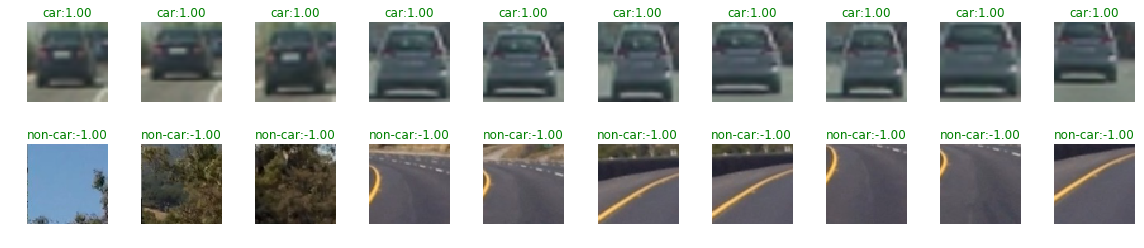

In [5]:
car_samples, car_labels = get_samples(x, y, class_label=1)
noncar_samples, noncar_labels = get_samples(x, y, class_label=-1)

samples = np.vstack((car_samples, noncar_samples))
labels = np.concatenate((car_labels, noncar_labels))
plot_batch(samples, labels)

In [6]:
# Split the dataset into training, validation, and testing
x_train, x_test, y_train, y_test = train_test_split(x.astype(np.float32), y.astype(np.float32), test_size=0.1, stratify=y, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=x_test.shape[0], stratify=y_train, random_state=42)

print_info(x_train, y_train)
print_info(x_val, y_val)
print_info(x_test, y_test)

x: (14208, 64, 64, 3) float32 	 y: (14208,) float32 	 counts: {-1.0: 7174, 1.0: 7034}
x: (1776, 64, 64, 3) float32 	 y: (1776,) float32 	 counts: {-1.0: 897, 1.0: 879}
x: (1776, 64, 64, 3) float32 	 y: (1776,) float32 	 counts: {-1.0: 897, 1.0: 879}


# 2. Graph Constrution

In [7]:
tf.reset_default_graph()

convnet = input_data(shape=[None, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS], name='input')

convnet = conv_2d(convnet, nb_filter=10, filter_size=3, activation='relu', weights_init='xavier')
convnet = conv_2d(convnet, nb_filter=10, filter_size=3, activation='relu', weights_init='xavier')
convnet = max_pool_2d(convnet, kernel_size=8, strides=8)
convnet = dropout(convnet, keep_prob=0.75)
convnet = conv_2d(convnet, nb_filter=128, filter_size=8, activation='relu', padding='valid', weights_init='xavier')
convnet = dropout(convnet, keep_prob=0.5)
convnet = conv_2d(convnet, nb_filter=1, filter_size=1, activation='tanh', padding='valid')

reg = regression(tf.reshape(convnet, [-1]), optimizer='adadelta', learning_rate=1.0, loss='mean_square', name='target')
print(reg.shape)

(?,)


# 3. Training and Evaluation 

In [8]:
def custom_accuracy(y_true, y_pred):
    y_pred = np.where(y_pred > 0, 1, -1)
    return accuracy_score(y_true, y_pred)*100

In [9]:
# rerun 'Graph Constrution' cell to refit model
model = tflearn.DNN(reg, tensorboard_dir=LOG_DIR)
model.fit({'input':x_train}, {'target':y_train}, n_epoch=5, batch_size=128, validation_set=({'input':x_val}, {'target':y_val}))

y_pred = model.predict({'input':x_test})
print('Test Accuracy: {:.2f}%'.format(custom_accuracy(y_test, y_pred)))

Training Step: 554  | total loss: 0.35047 | time: 48.944s
| AdaDelta | epoch: 005 | loss: 0.35047 -- iter: 14080/14208
Training Step: 555  | total loss: 0.33528 | time: 52.350s
| AdaDelta | epoch: 005 | loss: 0.33528 | val_loss: 0.32154 -- iter: 14208/14208
--
Test Accuracy: 91.33%


In [10]:
model.save(MODELS_DIR+MODEL_NAME)

INFO:tensorflow:C:\Users\Pesquisa\Documents\Arnaldo\Vehicles\models\cnn_cars is not in all_model_checkpoint_paths. Manually adding it.


__After training, run tensorboard with the code below:__
```sh
$ tensorboard --logdir=log
```

# 4. Restore and Testing 

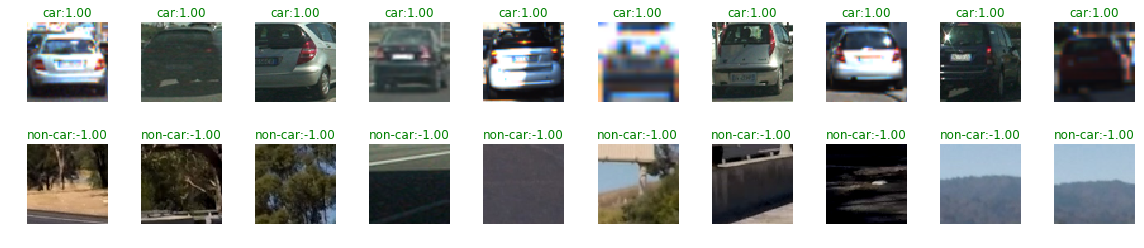

In [11]:
car_test, car_labels = get_samples(x_test, y_test, class_label=1)
noncar_test, noncar_labels = get_samples(x_test, y_test, class_label=-1)

test_batch = np.vstack((car_test, noncar_test))
test_labels = np.concatenate((car_labels, noncar_labels))

plot_batch(test_batch, test_labels, test_labels)

INFO:tensorflow:Restoring parameters from C:\Users\Pesquisa\Documents\Arnaldo\Vehicles\models\cnn_cars


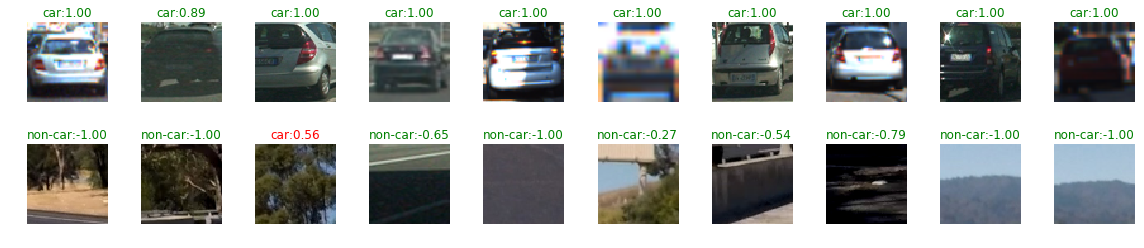

In [12]:
model.load(MODELS_DIR+MODEL_NAME)

test_pred = model.predict({'input':test_batch})
plot_batch(test_batch, test_labels, test_pred)

# 5. References

- [Original Article](https://medium.com/@tuennermann/convolutional-neural-networks-to-find-cars-43cbc4fb713)
- [Original Code (in Keras)](https://github.com/HTuennermann/Vehicle-Detection-and-Tracking)
- [Vehicle Dataset](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [Non-Vehicle Dataset](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip)
- [Using Convolutional Neural Network to Identify Dogs vs Cats](https://www.youtube.com/watch?v=27FPv1VHSsQ&list=WL&index=4)